In [1]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Stock_Price_Prediction
! ls

/content/drive/My Drive/Stock_Price_Prediction
data  WIPRO_Stock_Forecasting_with_LSTMs.ipynb


In [82]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Stock_Price_Prediction/data/TATASTEEL.csv')

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']]

df

,Date,Open,High,Low,Close,VWAP,Volume
0,2000-01-03,148.00,153.20,146.10,152.45,150.92,2003185
1,2000-01-04,150.10,153.00,143.05,150.80,151.03,1555136
2,2000-01-05,144.60,162.90,144.60,156.55,156.85,3840284
3,2000-01-06,158.95,169.10,158.95,168.25,167.61,2560449
4,2000-01-07,173.40,179.00,166.30,171.95,173.89,3641691
...,...,...,...,...,...,...,...
5301,2021-04-26,935.00,956.00,930.05,940.75,942.98,21234858
5302,2021-04-27,948.30,983.00,944.30,977.75,965.43,24904515
5303,2021-04-28,985.00,986.00,962.00,971.40,972.08,20447968
5304,2021-04-29,983.00,1036.95,983.00,1031.35,1015.76,44718647


In [83]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2000-01-03,152.45
1,2000-01-04,150.80
2,2000-01-05,156.55
3,2000-01-06,168.25
4,2000-01-07,171.95
...,...,...
5301,2021-04-26,940.75
5302,2021-04-27,977.75
5303,2021-04-28,971.40
5304,2021-04-29,1031.35


In [84]:
df['Date']

0       2000-01-03
1       2000-01-04
2       2000-01-05
3       2000-01-06
4       2000-01-07
           ...    
5301    2021-04-26
5302    2021-04-27
5303    2021-04-28
5304    2021-04-29
5305    2021-04-30
Name: Date, Length: 5306, dtype: object

In [85]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [86]:
df

,Date,Close
0,2000-01-03,152.45
1,2000-01-04,150.80
2,2000-01-05,156.55
3,2000-01-06,168.25
4,2000-01-07,171.95
...,...,...
5301,2021-04-26,940.75
5302,2021-04-27,977.75
5303,2021-04-28,971.40
5304,2021-04-29,1031.35


In [87]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-87-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5301   2021-04-26
5302   2021-04-27
5303   2021-04-28
5304   2021-04-29
5305   2021-04-30
Name: Date, Length: 5306, dtype: datetime64[ns]

In [88]:
df.index = df.pop('Date')
df

,Close
Date,
2000-01-03,152.45
2000-01-04,150.80
2000-01-05,156.55
2000-01-06,168.25
2000-01-07,171.95
...,...
2021-04-26,940.75
2021-04-27,977.75
2021-04-28,971.40


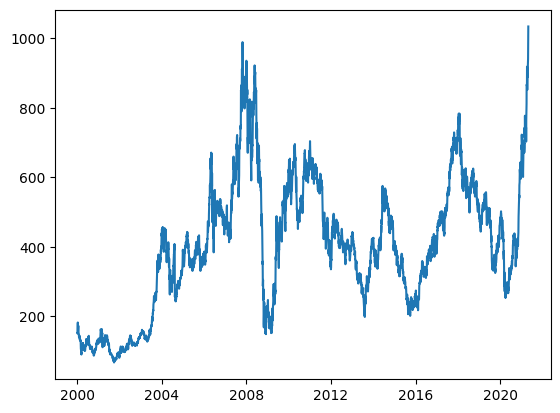

In [89]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [90]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2020-02-01',
                                '2021-04-30',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-02-01,452.20,448.55,438.70,423.80
1,2020-02-03,448.55,438.70,423.80,436.05
2,2020-02-04,438.70,423.80,436.05,451.90
3,2020-02-05,423.80,436.05,451.90,475.05
4,2020-02-06,436.05,451.90,475.05,477.60
...,...,...,...,...,...
304,2021-04-26,894.00,921.40,925.60,940.75
305,2021-04-27,921.40,925.60,940.75,977.75
306,2021-04-28,925.60,940.75,977.75,971.40
307,2021-04-29,940.75,977.75,971.40,1031.35


In [91]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((309,), (309, 3, 1), (309,))

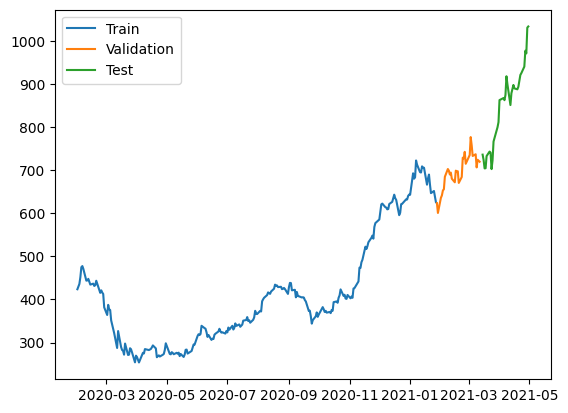

In [92]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
8/8 [==============================] - 5s 123ms/step - loss: 184422.4688 - mean_absolute_error: 411.3230 - val_loss: 486499.1562 - val_mean_absolute_error: 696.3746
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 183712.4375 - mean_absolute_error: 410.4554 - val_loss: 485287.4688 - val_mean_absolute_error: 695.5040
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 182945.4062 - mean_absolute_error: 409.5261 - val_loss: 483885.3438 - val_mean_absolute_error: 694.4953
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 182069.5469 - mean_absolute_error: 408.4474 - val_loss: 482214.9688 - val_mean_absolute_error: 693.2916
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 180937.6719 - mean_absolute_error: 407.0584 - val_loss: 480003.7500 - val_mean_absolute_error: 691.6951
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 179516.8281 - mean_absolute_error: 405.2969 - v

8/8 [==============================] - 0s 2ms/step


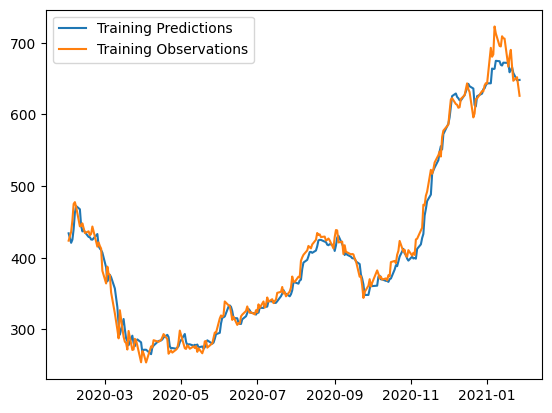

In [94]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


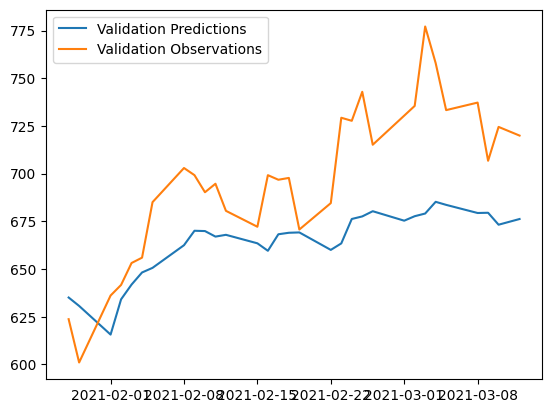

In [95]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 29ms/step


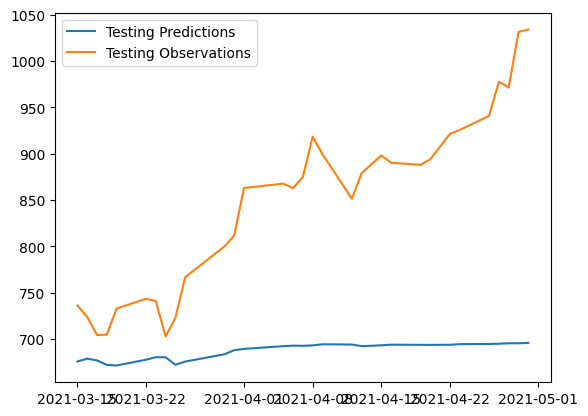

In [96]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

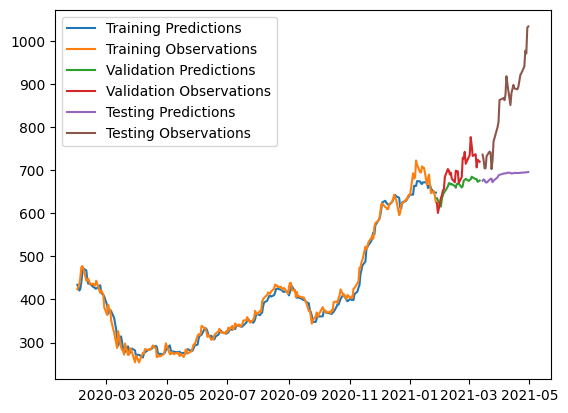

In [97]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [98]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


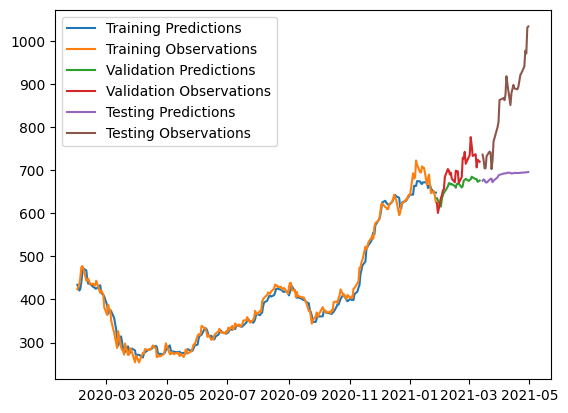

In [99]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

In [100]:
from sklearn import metrics

y_pred = test_predictions
# y_test = test_Observations


# Calculate the mean absolute error (MAE)
mae = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

# Calculate the mean squared error (MSE)
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Mean Absolute Percentage Error:', mape)

# Calculate the median absolute percentage error (MdAPE)
mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
print('Median Absolute Percentage Error:', mdape)

# Calculate the symmetric mean absolute percentage error (SMAPE)
smape = 100/len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
print('Symmetric Mean Absolute Percentage Error:', smape)

# R-2 score
r2 = metrics.r2_score(y_test, y_pred)
print('R-2 score:', r2)

#adjusted R square
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('Adjusted R-2 score:', adj_r2)

#accuracy
accuracy = 100 - smape
print('Accuracy:', accuracy)


Mean Absolute Error: 160.16309
Mean Squared Error: 33600.867
Root Mean Squared Error: 183.30539
Mean Absolute Percentage Error: 17.920324206352234
Median Absolute Percentage Error: 20.20331621170044
Symmetric Mean Absolute Percentage Error: 20.165807970108524
R-2 score: 2.594153181870885
Adjusted R-2 score: 2.9935035354120942
Accuracy: 79.83419202989148
